In [10]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import TFIDF
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from pandas import get_dummies
import pickle
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

def testing(df):
    from collections import Counter
    #fig2 = plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
    y=df['style_2'].tolist()
    print(Counter(y))
    

def getData():
    username = 'postgres'
    password = 'thisisforetsyapp'
    host     = 'localhost'
    port     = '5432'            # default port that postgres listens on
    db_name  = 'etsy_db'
    db_table = 'etsy_item_table'

    # Connect to make queries using psycopg2
    con = None
    con = psycopg2.connect(database = db_name, user = username, host=host, password = password)

    # query:
    sql_query = "SELECT * FROM " + db_table + ";"
    etsy_data_from_sql = pd.read_sql_query(sql_query,con)
    
    title_list = list(etsy_data_from_sql['title'])
    del etsy_data_from_sql['title']
    del etsy_data_from_sql['index']
    
    return etsy_data_from_sql, title_list


def plotCategoryCount(df):
    #fig2 = plt.figure(figsize=(14, 6), dpi= 80, facecolor='w', edgecolor='k')
    bg_color = (0.75, 0.75, 0.75)
    sns.set(rc={"font.style":"normal",
            "axes.facecolor":bg_color,
            "figure.facecolor":bg_color,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':25,
            'figure.figsize':(10.0, 8.0),
            'xtick.labelsize':20,
            'ytick.labelsize':20})
    fig = sns.countplot(y = df['category_id1'],
              order = df['category_id1'].value_counts()[:22].index)
    #fig  = sns.countplot(y=df['category_id1'])
    fig.axes.xaxis.label.set_text("Counts")
    fig.axes.yaxis.label.set_text("Categories")
    fig.figure.savefig("category_dist.png")
    return fig
    
def plotWhoMade(df):
    data_plot = df[['who_made', 'price']]
    fig2      = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
    fig       = sns.stripplot(x="who_made", y="price", data=data_plot, jitter=True)
    fig.figure.savefig("WhoMadeVsPrice.png")
    return fig

def plotWhenMade(df):
    data_plot2 = df[['when_made', 'price']]
    fig2       = plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
    fig        = sns.stripplot(y="when_made", x="price", data=data_plot2, jitter=True)
    fig.figure.savefig("WhenMadeVsPrice.png")
    return fig

def plotSellerScore(df):
    data_plot3 = df[['seller_score', 'price']]
    fig2       = plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
    fig        = plt.scatter(data_plot3['seller_score'], data_plot3['price'])
    plt.xlabel('seller score rating')
    plt.ylabel('item price')
    fig.figure.savefig("SellerScoreVsPrice.png")


def data_preprocessing(df, df_title):
    print('processing data...')
    categorical_col = ['category_id1', 'category_id2', 'category_id3', 'material', 'who_made', 'when_made', 'style_1', 'style_2']
    indexing = 0
    for cat_name in categorical_col:
        indexing += 1
        values = df[cat_name]
        counts = pd.value_counts(values)
        mask = values.isin(counts[counts > 50].index)
        temp = get_dummies(values[mask])
        column_names = temp.columns
        column_names_fixed = [cat_name+x for x in column_names]
        temp.columns = column_names_fixed
        print(len(column_names_fixed))
        if indexing == 1:
            df_cat_oneHot = temp
        else:
            df_cat_oneHot = pd.concat([df_cat_oneHot, temp], axis=1)

    non_categorical_col = list(df.columns.drop(categorical_col))
    print(non_categorical_col)
    df_others = df[non_categorical_col]
    df_without_title = pd.concat([df_others, df_cat_oneHot], axis=1)
    df_organized = pd.concat([df_title, df_without_title], axis=1)


    df_organized = df_organized.sample(frac=1, random_state=321).reset_index(drop=True)
    df_organized.fillna(0, inplace=True)
    train_df_len = int(len(df_organized)/5*4)
    train_df = df_organized.iloc[0:train_df_len]
    test_df = df_organized.iloc[train_df_len:len(df)]


    features = list(train_df.columns)
    features.remove('price')

    train_x = train_df[features]
    train_y = train_df['price']

    test_x = test_df[features]
    test_y = test_df['price']
    return train_x, train_y, test_x, test_y

def train_create_model(train_x, train_y):
    print('training and creating model...')
    RF_regr = RandomForestRegressor(random_state=0, n_estimators=500, n_jobs=-1)
    RF_regr.fit(train_x, train_y)
    print('done')

    print("saving model to 'machine_learning_model'...")
    with open("machine_learning_model", "wb") as fp:
        pickle.dump(RF_regr, fp)
    print('completed!')
    return 'machine_learning_model'

def load_model(model_name):
    with open(model_name, "rb") as fp:
        RF_regr_new = pickle.load(fp)
    return RF_regr_new


def calculate_rmse(RF_regr_new, test_x, test_y):
    predicted_price = RF_regr_new.predict(test_x)
    plt.scatter(predicted_price, test_y)
    plt.xlabel('predicted value')
    plt.ylabel('item price')
    plt.show()

    rms = sqrt(mean_squared_error(test_y, predicted_price))
    return predicted_price, rms

def analysis(test_x, test_y, predicted_price):
    print(test_x.columns[515:537])
    category_bad = []
    summing = np.array([0] * 22)
    for i in range(0, len(test_y)):
        if abs(test_y.iloc[i]-predicted_price[i]) > 300:
            summing = np.add(summing, test_x.iloc[i][515:537])
    print(summing)

def analysis_category_removed(test_x, test_y, predicted_price):
    test_y_organized = []
    predicted_price_organized = []

    for i in range(0, len(test_y)):
        if test_x.iloc[i][527] != 1 and test_x.iloc[i][516] != 1 and test_x.iloc[i][522] != 1 and test_x.iloc[i][526] != 1:
            test_y_organized.append(test_y.iloc[i])
            predicted_price_organized.append(predicted_price[i])

    plt.scatter(predicted_price_organized, test_y_organized)
    plt.xlabel('predicted value')
    plt.xlim([0, 1000])
    plt.ylim([0,1000])
    plt.ylabel('item price')
    plt.show()

    rms = sqrt(mean_squared_error(test_y_organized, predicted_price_organized))
    return rms, predicted_price_organized, test_y_organized

def trainingSetAnalysis(train_x, train_y, RF_regr_new):
    predicted_price_x = RF_regr_new.predict(train_x)
    plt.scatter(predicted_price_x, train_y)
    plt.xlabel('predicted value')
    plt.ylabel('item price')
    plt.show()

    rms = sqrt(mean_squared_error(train_y, predicted_price_x))
    return rms, predicted_price_x

if __name__=='__main__':
    #df, title_list = getData()
    #testing(df)
    

    df, title_list = getData()
    #plotCategoryCount(df)
    #plotWhoMade(df)
    #plotWhenMade(df)
    #plotSellerScore(df)
    title_splitted, tfidf_model = TFIDF.tfidf_transform(title_list, 500)
    
    

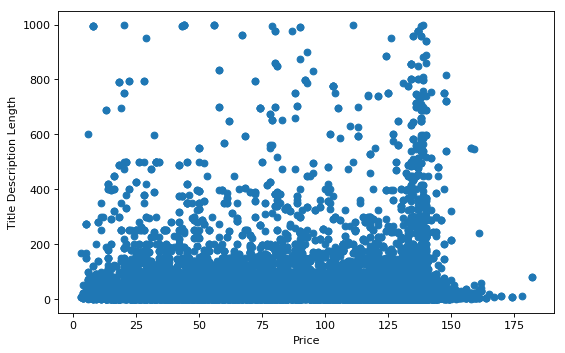

0.005229166836876752


In [11]:
title_length=[]
for titleString in title_list:
    title_length.append(len(titleString))
price_array = df['price'].tolist()
fig = plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(x=title_length, y=price_array)
plt.xlabel('Price')
#plt.xlim([0, 1000])
#plt.ylim([0,1000])
plt.ylabel('Title Description Length')
plt.show()
print(np.corrcoef(title_length, price_array)[0, 1])

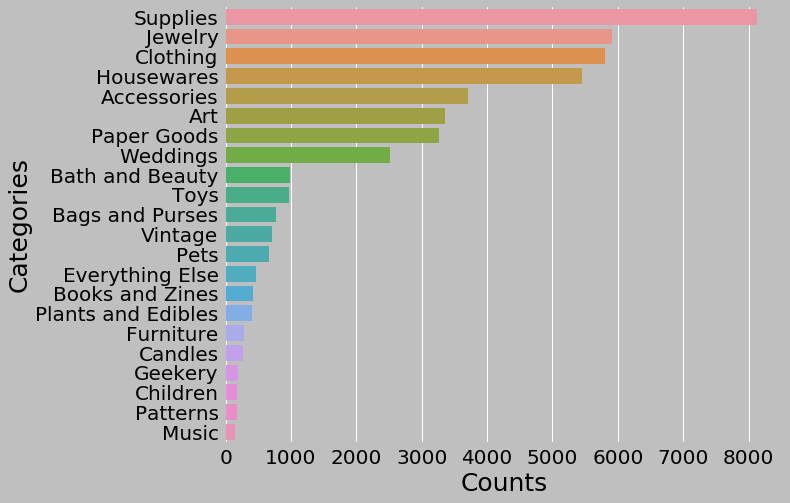

In [26]:
plotCategoryCount(df)

In [23]:
for i in range(1,1000):
   if df.iloc[i]['price']>300:
      print(df.iloc[i])
      print(title_list[i])

category_id1              Bath and Beauty
category_id2                         none
category_id3                         none
quantity                                1
material                             none
who_made                            i_did
when_made                   made_to_order
item_weight                            16
item_weight_indicator                   1
item_length                            12
item_length_indicator                   1
item_width                              5
item_width_indicator                    1
item_height                             1
item_height_indicator                   1
style_1                              none
style_2                              none
non_taxable                             0
is_customizable                         1
is_digital_download                     0
seller_feedback_count                   3
seller_score                          100
seller_score_indicator                  1
price                             

In [55]:
test = title_splitted.toarray()
print(len(test[0]))

500


In [1]:
    
    with open('title_list', "wb") as fp:
        pickle.dump(title_list, fp)
    

    title_array = title_splitted.toarray()
    df_title = pd.DataFrame(title_array)
    train_x, train_y, test_x, test_y = data_preprocessing(df, df_title)
    
    

processing data...
22
76
27
78
3
14
34
35
['quantity', 'item_weight', 'item_weight_indicator', 'item_length', 'item_length_indicator', 'item_width', 'item_width_indicator', 'item_height', 'item_height_indicator', 'non_taxable', 'is_customizable', 'is_digital_download', 'seller_feedback_count', 'seller_score', 'seller_score_indicator', 'price']


In [40]:
labels = list(test_x.columns.values)
print(labels)
print(test_x.loc[35816, 'quantity':'style_2none'])
print(len(test_x.columns.values))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

quantity                          87.0
item_weight                        0.0
item_weight_indicator              0.0
item_length                        0.0
item_length_indicator              0.0
item_width                         0.0
item_width_indicator               0.0
item_height                        0.0
item_height_indicator              0.0
non_taxable                        0.0
is_customizable                    0.0
is_digital_download                0.0
seller_feedback_count          12360.0
seller_score                      99.0
seller_score_indicator             1.0
category_id1Accessories            0.0
category_id1Art                    0.0
category_id1Bags and Purses        0.0
category_id1Bath and Beauty        0.0
category_id1Books and Zines        0.0
category_id1Candles                0.0
category_id1Children               0.0
category_id1Clothing               0.0
category_id1Everything Else        0.0
category_id1Furniture              0.0
category_id1Geekery      

processing data...
22
76
27
78
3
14
34
35
['quantity', 'item_weight', 'item_weight_indicator', 'item_length', 'item_length_indicator', 'item_width', 'item_width_indicator', 'item_height', 'item_height_indicator', 'non_taxable', 'is_customizable', 'is_digital_download', 'seller_feedback_count', 'seller_score', 'seller_score_indicator', 'price']


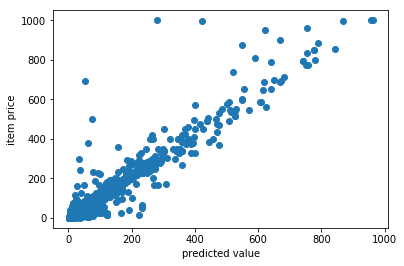

19.387062042484594


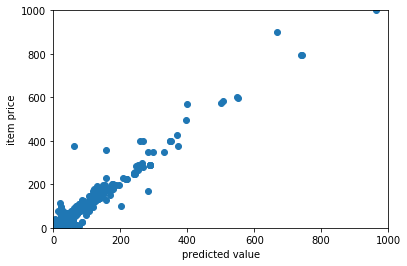

10.260874700428507


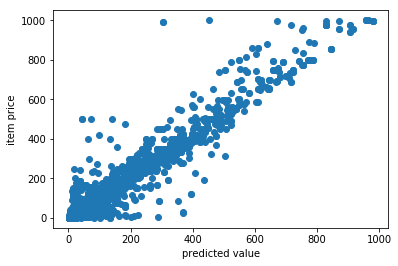

16.254245589368963


In [3]:
    """
    Note that this model training can take quite some time. However,
    when the model has been trained once, it saves to a binary file.
    Therefore, just need to load the model from file directly for
    later use. Please comment out "model_name = train_create_model(train_x, train_y)"
    if you have run it once and have model saved already.
    """
    #model_name = train_create_model(train_x, train_y)
    rfrModel=load_model("machine_learning_model_500wordfeatures")
   
    
    predicted_price, rms = calculate_rmse(rfrModel, test_x, test_y)
    print(rms)
    rms_category_removed, predicted_price_organized, test_y_organized = analysis_category_removed(test_x, test_y, predicted_price)
    print(rms_category_removed)
    rms_training, predicted_price_x = trainingSetAnalysis(train_x, train_y, rfrModel)
    print(rms_training)

    #data_dic = {}
    #data_dic['train_x'] = train_x
    #data_dic['train_y'] = train_y
    #data_dic['test_x'] = test_x
    #data_dic['test_y'] = test_y
    #with open("analysis_data_backup", "wb") as fp:
    #    pickle.dump(data_dic, fp)